In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import numpy as np
import seaborn as sns

!pip install -U -q PyDrive
!pip install scikit-plot
!pip install featurewiz

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


downloaded = drive.CreateFile({'id':'1q1Ha1e9K9VJD8nCeggB8VKD4jN9UJaIN'}) # replace the id with id of file you want to access
downloaded.GetContentFile('IADSED.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


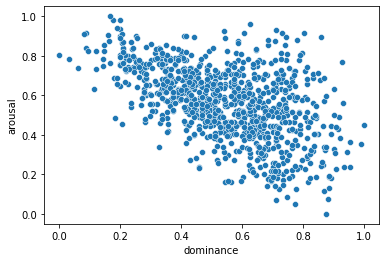

In [ ]:
sound = pd.read_csv('IADSED.csv')
df = pd.DataFrame(sound)
nullCount = df.columns[df.isnull().any()]
# All the columns that have missing data are numeric, so I'm using the mean to fill the null values
df.fillna(df.mean(), inplace=True)
df_num = df.drop(df.loc[:, 'source':'BE_Classification'].columns, axis=1, inplace=False)
df.head()

# normalize the data attributes
scaler = MinMaxScaler()
scaledDf = pd.DataFrame(scaler.fit_transform(df_num),index=df_num.index, columns=df_num.columns, ) 

#fig, axs = plt.subplots(ncols=3,figsize=(90,20))
sns.scatterplot(data=scaledDf, x='dominance', y='arousal')


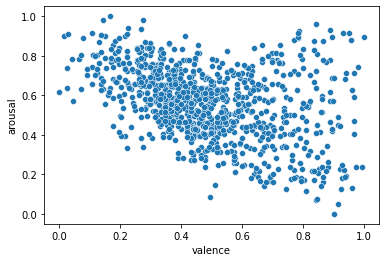

In [ ]:
sns.scatterplot(data=scaledDf, x='valence', y='arousal')


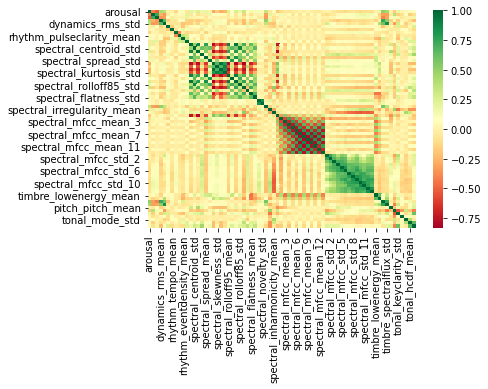

In [ ]:
sns.heatmap(scaledDf.corr(),cmap='RdYlGn')

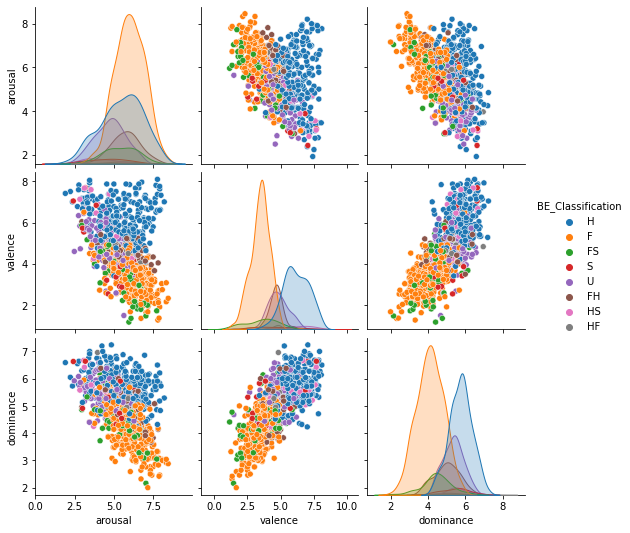

In [ ]:
dfPair = df.iloc[:, 4:8]
dfPair.head()
sns.pairplot(dfPair, hue="BE_Classification") 

In [ ]:
df1 = scaledDf[["arousal","dynamics_rms_mean"]]
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm')

,arousal,dynamics_rms_mean
arousal,1.000000,0.430811
dynamics_rms_mean,0.430811,1.000000


In [ ]:
# Splitting the dataset into training and testing data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
X = scaledDf.iloc[:,scaledDf.columns != 'dominance'].values # these are factors for the prediction
X = scaledDf[['arousal', 'valence', 'dynamics_rms_mean', 'spectral_centroid_std',
       'spectral_skewness_mean', 'spectral_irregularity_mean',
       'spectral_inharmonicity_mean', 'spectral_mfcc_mean_1',
       'spectral_mfcc_mean_4', 'tonal_hcdf_std']].values
# X = scaledDf[['arousal', 'valence', 'dynamics_rms_std', 'rhythm_attacktime_mean',
#        'rhythm_eventdensity_mean', 'rhythm_fluctuationmax_peakposmean']].values
#X = scaledDf.iloc[:, [0] + [1] + list(range(3,71)) ].values
# X = scaledDf[['arousal', 'valence', 'dynamics_rms_std', 'rhythm_attacktime_mean',
#        'rhythm_tempo_mean', 'rhythm_tempo_std', 'rhythm_pulseclarity_mean',
#        'rhythm_eventdensity_mean', 'rhythm_fluctuationmax_peakposmean']].values
y = scaledDf.iloc[:,2].values # this is what we want to predict

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=34)

def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=10)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
# X_train, X_test, fs = select_features(X_train, y_train, X_test)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import numpy as np
lr_model = LinearRegression()
lr_model.fit(X_train, y_train.ravel())
lr_model_train = lr_model.predict(X_train)
print(metrics.mean_squared_error(y_train, lr_model_train, squared=False)) #squared = False returns RMSE
lr_model_test = lr_model.predict(X_test)
print(metrics.mean_squared_error(y_test, lr_model_test, squared=False))

0.10370609686118534
0.10248546309456624


In [ ]:
svrPoly = SVR(kernel="poly", C = 1, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svrPoly.fit(X_train, y_train.ravel())
svr_model_train = svrPoly.predict(X_train)
print(metrics.mean_squared_error(y_train, svr_model_train, squared=False)) #squared = False returns RMSE
svr_model_test = svrPoly.predict(X_test)
print(metrics.mean_squared_error(y_test, svr_model_test, squared=False))


0.10007276200124203
0.10126961883392674


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


kf = KFold(n_splits=5)
list_training_error = []
list_testing_error = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index]
  svrPoly.fit(X_train, y_train)
  y_train_data_pred = svrPoly.predict(X_train)
  y_test_data_pred = svrPoly.predict(X_test)
  fold_training_error = metrics.mean_squared_error(y_train, y_train_data_pred,squared=False)
  fold_testing_error = metrics.mean_squared_error(y_test, y_test_data_pred,squared=False)
  list_training_error.append(fold_training_error)
  list_testing_error.append(fold_testing_error)

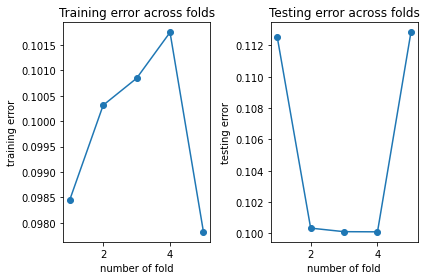

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
plt.xlabel('number of fold') 
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel("testing error")
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

In [ ]:
kf = KFold(n_splits=5)
list_training_error = []
list_testing_error = []
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index]
  lr_model.fit(X_train, y_train)
  y_train_data_pred = lr_model.predict(X_train)
  y_test_data_pred = lr_model.predict(X_test)
  fold_training_error = metrics.mean_squared_error(y_train, y_train_data_pred,squared=False)
  fold_testing_error = metrics.mean_squared_error(y_test, y_test_data_pred,squared=False)
  list_training_error.append(fold_training_error)
  list_testing_error.append(fold_testing_error)

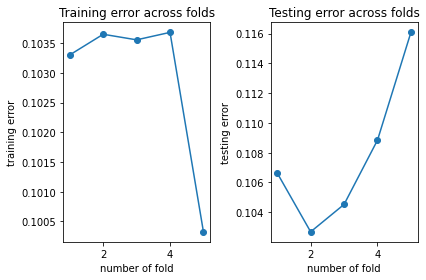

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
plt.xlabel('number of fold') 
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel("testing error")
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

In [ ]:
# 5 fold Cross Validation

scores_arou_lr = cross_val_score(lr_model, X_test, y_test, cv=5)
scores_arou_poly = cross_val_score(svrPoly, X_test, y_test, cv=5)
print("%0.3f accuracy for Linear Regression with a standard deviation of %0.3f" % (scores_arou_lr.mean(), scores_arou_lr.std()))
print("%0.3f accuracy for Support Vector Regression with a standard deviation of %0.3f" % (scores_arou_poly.mean(), scores_arou_poly.std()))

0.600 accuracy for Linear Regression with a standard deviation of 0.126
0.617 accuracy for Support Vector Regression with a standard deviation of 0.094


In [ ]:
# import sklearn.externals as extjoblib
# import joblib
# from sklearn.feature_selection import SequentialFeatureSelector as sfs
# from sklearn.linear_model import LinearRegression

# lreg = LinearRegression()
  
# sfs1 = sfs(lreg, n_features_to_select=10, direction='backward')
# sfs1 = sfs1.fit(X, y)
# indices = sfs1.get_support(indices=True)

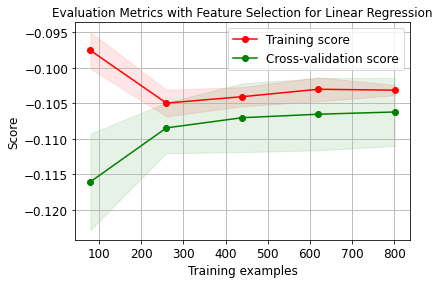

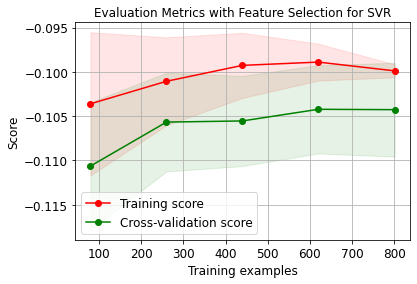

In [ ]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr_model, X, y,
                                     cv=7, shuffle=True,n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large", scoring='neg_root_mean_squared_error',
                                     title="Evaluation Metrics with Feature Selection for Linear Regression");
skplt.estimators.plot_learning_curve(svrPoly, X, y,
                                     cv=7, shuffle=True,n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large", scoring='neg_root_mean_squared_error',
                                     title="Evaluation Metrics with Feature Selection for SVR");

In [ ]:
scaledDf

,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,rhythm_attacktime_mean,rhythm_tempo_mean,rhythm_tempo_std,rhythm_pulseclarity_mean,rhythm_eventdensity_mean,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
0,0.347021,0.776316,0.711832,0.122978,0.117740,0.051217,0.439822,0.012797,0.220125,0.176471,...,0.335939,0.134705,0.070679,0.206011,0.516918,0.286804,0.574507,0.508362,0.167954,0.218309
1,0.652400,0.296053,0.295802,0.099422,0.107828,0.037285,0.479631,0.496218,0.171065,0.220588,...,0.645832,0.203858,0.106516,0.252204,0.635515,0.398061,0.588421,0.742350,0.298956,0.218103
2,0.506651,0.440789,0.425573,0.087254,0.103867,0.068410,0.639954,0.179055,0.317891,0.382353,...,0.539169,0.138830,0.081974,0.216708,0.543738,0.429740,0.568621,0.240946,0.120885,0.174737
3,0.548294,0.480263,0.545802,0.103992,0.134379,0.042033,0.484913,0.485126,0.212141,0.264706,...,0.581285,0.168087,0.106586,0.218940,0.749226,0.230050,0.462012,0.490683,0.189204,0.164961
4,0.707345,0.438048,0.358779,0.120006,0.059853,0.058306,0.552794,0.236969,0.277470,0.411765,...,0.301156,0.191831,0.048808,0.187749,0.549472,0.314861,0.716657,0.655168,0.188338,0.149962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,0.516484,0.860197,0.604962,0.143337,0.101253,0.022053,0.775843,0.044821,0.183254,0.161765,...,0.436489,0.170868,0.086272,0.166039,0.746644,0.335323,0.573135,0.711551,0.138557,0.241691
931,0.872759,0.836075,0.708015,0.226747,0.260889,0.045320,0.696687,0.005675,0.592805,0.470588,...,0.589924,0.510105,0.331794,0.229720,0.606857,0.425452,0.499972,0.656759,0.414654,0.786798
932,0.700983,0.824013,0.770992,0.123030,0.173572,0.041992,0.613370,0.388297,0.146129,0.205882,...,0.632748,0.224257,0.211516,0.229219,0.662354,0.490158,0.363041,0.462807,0.253389,0.556021
933,0.582996,0.861842,0.814885,0.219580,0.111945,0.116520,0.649841,0.548354,0.191010,0.279412,...,0.505461,0.199558,0.101838,0.251412,0.714805,0.283779,0.451452,0.637426,0.147114,0.195331


In [ ]:
def label_class (row):
   if row['arousal'] <= 0.5 and row['valence'] <= 0.5:
      return 3
   if row['arousal'] <= 0.5 and row['valence'] > 0.5:
      return 4
   if row['arousal'] > 0.5 and row['valence'] <= 0.5:
      return 2
   if row['arousal'] > 0.5 and row['valence'] > 0.5:
      return 1
   return 'Other'

scaledDfClass = scaledDf

In [ ]:
scaledDfClass['class_label'] = scaledDfClass.apply (lambda row: label_class(row), axis=1)

In [ ]:
scaledDfClass

,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,rhythm_attacktime_mean,rhythm_tempo_mean,rhythm_tempo_std,rhythm_pulseclarity_mean,rhythm_eventdensity_mean,...,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std,class_label
0,0.347021,0.776316,0.711832,0.122978,0.117740,0.051217,0.439822,0.012797,0.220125,0.176471,...,0.134705,0.070679,0.206011,0.516918,0.286804,0.574507,0.508362,0.167954,0.218309,4
1,0.652400,0.296053,0.295802,0.099422,0.107828,0.037285,0.479631,0.496218,0.171065,0.220588,...,0.203858,0.106516,0.252204,0.635515,0.398061,0.588421,0.742350,0.298956,0.218103,2
2,0.506651,0.440789,0.425573,0.087254,0.103867,0.068410,0.639954,0.179055,0.317891,0.382353,...,0.138830,0.081974,0.216708,0.543738,0.429740,0.568621,0.240946,0.120885,0.174737,2
3,0.548294,0.480263,0.545802,0.103992,0.134379,0.042033,0.484913,0.485126,0.212141,0.264706,...,0.168087,0.106586,0.218940,0.749226,0.230050,0.462012,0.490683,0.189204,0.164961,2
4,0.707345,0.438048,0.358779,0.120006,0.059853,0.058306,0.552794,0.236969,0.277470,0.411765,...,0.191831,0.048808,0.187749,0.549472,0.314861,0.716657,0.655168,0.188338,0.149962,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,0.516484,0.860197,0.604962,0.143337,0.101253,0.022053,0.775843,0.044821,0.183254,0.161765,...,0.170868,0.086272,0.166039,0.746644,0.335323,0.573135,0.711551,0.138557,0.241691,1
931,0.872759,0.836075,0.708015,0.226747,0.260889,0.045320,0.696687,0.005675,0.592805,0.470588,...,0.510105,0.331794,0.229720,0.606857,0.425452,0.499972,0.656759,0.414654,0.786798,1
932,0.700983,0.824013,0.770992,0.123030,0.173572,0.041992,0.613370,0.388297,0.146129,0.205882,...,0.224257,0.211516,0.229219,0.662354,0.490158,0.363041,0.462807,0.253389,0.556021,1
933,0.582996,0.861842,0.814885,0.219580,0.111945,0.116520,0.649841,0.548354,0.191010,0.279412,...,0.199558,0.101838,0.251412,0.714805,0.283779,0.451452,0.637426,0.147114,0.195331,1


In [ ]:
target = scaledDfClass['class_label']

ones = (target == 1).sum()
twos = (target == 2).sum()
threes = (target == 3).sum()
fours = (target == 4).sum()

print("Ones: {}\nTwos: {}\nThrees: {}\nFours: {}\n".format(ones, twos,threes,fours))

Ones: 183
Twos: 415
Threes: 129
Fours: 208



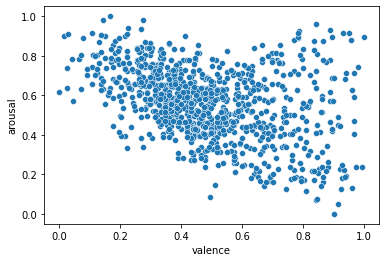

In [ ]:
sns.scatterplot(scaledDfClass['valence'], scaledDfClass['arousal'])

(array([183.,   0.,   0., 415.,   0.,   0., 129.,   0.,   0., 208.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

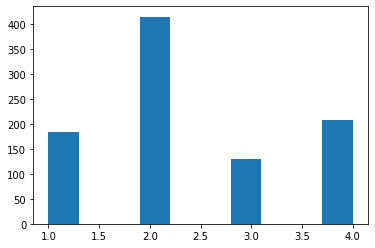

In [ ]:
plt.hist(scaledDfClass['class_label'])

In [ ]:
from sklearn.linear_model import LogisticRegression
from featurewiz import featurewiz

# X = scaledDfClass.iloc[:,scaledDfClass.columns != 'class_label'].values # these are factors for the prediction
X = scaledDfClass.iloc[:,2:71].values
# X = scaledDfClass[['dominance',
#  'dynamics_rms_mean',
#  'spectral_rolloff85_mean',
#  'timbre_spectralflux_std',
#  'tonal_keyclarity_mean',
#  'tonal_keyclarity_std',
#  'spectral_rolloff85_std',
#  'tonal_hcdf_mean',
#  'tonal_mode_mean',
#  'spectral_mfcc_mean_2',
#  'spectral_roughness_mean',
#  'spectral_mfcc_std_10',
#  'spectral_mfcc_mean_1',
#  'spectral_mfcc_mean_5',
#  'tonal_mode_std',
#  'spectral_mfcc_mean_8']].values

y = scaledDfClass['class_label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=76)
X

#features, train = featurewiz(scaledDfClass.iloc[:,2:72], 'class_label', verbose=2, sep=",", header=0,test_data="", feature_engg="", category_encoders="")

array([[0.71183206, 0.12297821, 0.11773984, ..., 0.50836171, 0.16795355,
        0.21830919],
       [0.29580153, 0.09942172, 0.10782811, ..., 0.74234968, 0.29895587,
        0.21810295],
       [0.42557252, 0.08725393, 0.10386701, ..., 0.24094598, 0.12088512,
        0.17473729],
       ...,
       [0.77099237, 0.12303033, 0.17357172, ..., 0.46280676, 0.25338892,
        0.55602102],
       [0.8148855 , 0.21957984, 0.11194456, ..., 0.6374256 , 0.14711432,
        0.19533141],
       [0.43320611, 0.06570826, 0.08416304, ..., 0.25980202, 0.10347881,
        0.19821716]])

In [ ]:
LogReg = LogisticRegression(max_iter=600)
LogReg.fit(X_train,y_train)

LogisticRegression(max_iter=600)

0.7393048128342246
0.6737967914438503


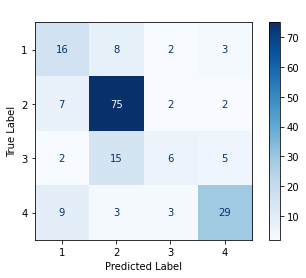

array([[16,  8,  2,  3],
       [ 7, 75,  2,  2],
       [ 2, 15,  6,  5],
       [ 9,  3,  3, 29]])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,classification_report

# LogReg.score(X,y)
model_train = LogReg.predict(X_train)
model_test = LogReg.predict(X_test)
print(LogReg.score(X_train,y_train))
print(LogReg.score(X_test,y_test))

color = 'white'
matrix = plot_confusion_matrix(LogReg, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_test, model_test)
confusion_matrix

In [ ]:
report = classification_report(y_test, model_test,output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
1,0.470588,0.551724,0.507937,29.000000
2,0.742574,0.872093,0.802139,86.000000
3,0.461538,0.214286,0.292683,28.000000
4,0.743590,0.659091,0.698795,44.000000
accuracy,0.673797,0.673797,0.673797,0.673797
macro avg,0.604573,0.574298,0.575388,187.000000
weighted avg,0.658553,0.673797,0.655916,187.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfModel = RandomForestClassifier(n_estimators = 8, random_state=24) 
rfModel.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = rfModel.predict(X_test)
print(rfModel.score(X_train,y_train))
print(rfModel.score(X_test,y_test))

0.9879679144385026
0.6417112299465241


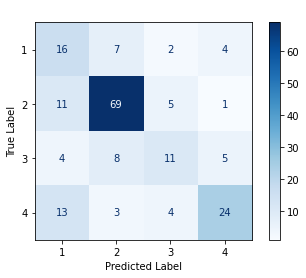

array([[16,  7,  2,  4],
       [11, 69,  5,  1],
       [ 4,  8, 11,  5],
       [13,  3,  4, 24]])

In [ ]:
from sklearn.metrics import plot_confusion_matrix

color = 'white'
matrix = plot_confusion_matrix(rfModel, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

In [ ]:
report = classification_report(y_test, y_pred,output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
1,0.363636,0.551724,0.438356,29.000000
2,0.793103,0.802326,0.797688,86.000000
3,0.500000,0.392857,0.440000,28.000000
4,0.705882,0.545455,0.615385,44.000000
accuracy,0.641711,0.641711,0.641711,0.641711
macro avg,0.590656,0.573090,0.572857,187.000000
weighted avg,0.662092,0.641711,0.645510,187.000000


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnModel = KNeighborsClassifier(n_neighbors=12)
knnModel.fit(X_train, y_train) 

# Predict y data with classifier: 
y_predict = knnModel.predict(X_test)
print(knnModel.score(X_train,y_train))
print(knnModel.score(X_test,y_test))

0.6590909090909091
0.6256684491978609


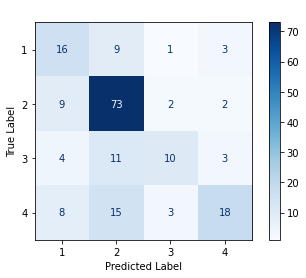

array([[16,  9,  1,  3],
       [ 9, 73,  2,  2],
       [ 4, 11, 10,  3],
       [ 8, 15,  3, 18]])

In [ ]:
from sklearn.metrics import plot_confusion_matrix

color = 'white'
matrix = plot_confusion_matrix(knnModel, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
confusion_matrix

In [ ]:
report = classification_report(y_test, y_predict,output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
1,0.432432,0.551724,0.484848,29.000000
2,0.675926,0.848837,0.752577,86.000000
3,0.625000,0.357143,0.454545,28.000000
4,0.692308,0.409091,0.514286,44.000000
accuracy,0.625668,0.625668,0.625668,0.625668
macro avg,0.606417,0.541699,0.551564,187.000000
weighted avg,0.634394,0.625668,0.610364,187.000000


Feature Selection for classification

In [ ]:
X = scaledDfClass[['dominance',
 'dynamics_rms_mean',
 'spectral_rolloff85_mean',
 'timbre_spectralflux_std',
 'tonal_keyclarity_mean',
 'tonal_keyclarity_std',
 'spectral_rolloff85_std',
 'tonal_hcdf_mean',
 'tonal_mode_mean',
 'spectral_mfcc_mean_2',
 'spectral_roughness_mean',
 'spectral_mfcc_std_10',
 'spectral_mfcc_mean_1',
 'spectral_mfcc_mean_5',
 'tonal_mode_std',
 'spectral_mfcc_mean_8']].values

y = scaledDfClass['class_label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=76)
X

#features, train = featurewiz(scaledDfClass.iloc[:,2:72], 'class_label', verbose=2, sep=",", header=0,test_data="", feature_engg="", category_encoders="")

array([[0.71183206, 0.12297821, 0.77391053, ..., 0.35955903, 0.50836171,
        0.61971301],
       [0.29580153, 0.09942172, 0.19830261, ..., 0.35716513, 0.74234968,
        0.61309708],
       [0.42557252, 0.08725393, 0.24176428, ..., 0.35222914, 0.24094598,
        0.64929655],
       ...,
       [0.77099237, 0.12303033, 0.14877585, ..., 0.38754043, 0.46280676,
        0.58925403],
       [0.8148855 , 0.21957984, 0.14673414, ..., 0.33841946, 0.6374256 ,
        0.6206939 ],
       [0.43320611, 0.06570826, 0.4815335 , ..., 0.38255287, 0.25980202,
        0.62256138]])

0.6885026737967914
0.6470588235294118


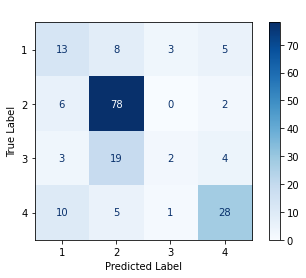

array([[13,  8,  3,  5],
       [ 6, 78,  0,  2],
       [ 3, 19,  2,  4],
       [10,  5,  1, 28]])

In [ ]:
from sklearn.metrics import plot_confusion_matrix,classification_report

LogReg = LogisticRegression(max_iter=600)
LogReg.fit(X_train,y_train)

# LogReg.score(X,y)
model_train = LogReg.predict(X_train)
model_test = LogReg.predict(X_test)
print(LogReg.score(X_train,y_train))
print(LogReg.score(X_test,y_test))

color = 'white'
matrix = plot_confusion_matrix(LogReg, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_test, model_test)
confusion_matrix

In [ ]:
report = classification_report(y_test, model_test, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
1,0.406250,0.448276,0.426230,29.000000
2,0.709091,0.906977,0.795918,86.000000
3,0.333333,0.071429,0.117647,28.000000
4,0.717949,0.636364,0.674699,44.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.541656,0.515761,0.503623,187.000000
weighted avg,0.607947,0.647059,0.608505,187.000000


0.9786096256684492
0.6470588235294118


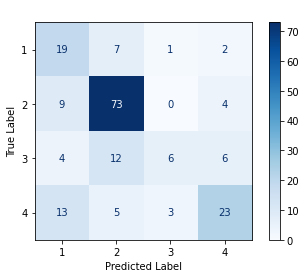

array([[19,  7,  1,  2],
       [ 9, 73,  0,  4],
       [ 4, 12,  6,  6],
       [13,  5,  3, 23]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfModel = RandomForestClassifier(n_estimators = 8, random_state=24) 
rfModel.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = rfModel.predict(X_test)
print(rfModel.score(X_train,y_train))
print(rfModel.score(X_test,y_test))



color = 'white'
matrix = plot_confusion_matrix(rfModel, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
1,0.422222,0.655172,0.513514,29.000000
2,0.752577,0.848837,0.797814,86.000000
3,0.600000,0.214286,0.315789,28.000000
4,0.657143,0.522727,0.582278,44.000000
accuracy,0.647059,0.647059,0.647059,0.647059
macro avg,0.607986,0.560256,0.552349,187.000000
weighted avg,0.656045,0.647059,0.630836,187.000000


0.7098930481283422
0.6256684491978609


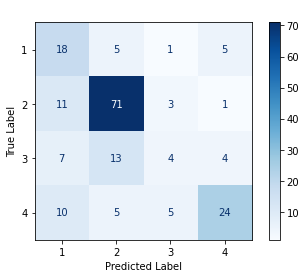

array([[18,  5,  1,  5],
       [11, 71,  3,  1],
       [ 7, 13,  4,  4],
       [10,  5,  5, 24]])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnModel = KNeighborsClassifier(n_neighbors=12)
knnModel.fit(X_train, y_train) 

# Predict y data with classifier: 
y_predict = knnModel.predict(X_test)
print(knnModel.score(X_train,y_train))
print(knnModel.score(X_test,y_test))


color = 'white'
matrix = plot_confusion_matrix(knnModel, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.show()
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
confusion_matrix

In [ ]:
report = classification_report(y_test, y_predict, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report

,precision,recall,f1-score,support
1,0.391304,0.620690,0.480000,29.000000
2,0.755319,0.825581,0.788889,86.000000
3,0.307692,0.142857,0.195122,28.000000
4,0.705882,0.545455,0.615385,44.000000
accuracy,0.625668,0.625668,0.625668,0.625668
macro avg,0.540050,0.533646,0.519849,187.000000
weighted avg,0.620211,0.625668,0.611256,187.000000
